### Libraries

In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from pyDOE import lhs
from torch import tensor
import torch.nn as nn
import scipy.io

### Parameters

In [78]:
torch.set_default_dtype(torch.double)
layer_sizes = [2, 20, 20, 20, 20, 20, 1]
activation = nn.Tanh()
num_epochs = 20000
lr = 1e-3
test_freq = 50
num_domain = 5000  # number of training collocation data points inside the domain
num_initial_boundary = 200  # number of training data point from initial and boundry data
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Burgers' Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}
$$

### Boundary Conditions:

$$ 
u(-1,t) = 0 \\ 
u(1,t) = 0
$$

### Initial Condition:

$$u(x,0) = -\sin(\pi x)$$


# Data + Visualization

In [79]:
data = scipy.io.loadmat('./burgers_shock.mat') # importing the true data
x = torch.tensor(data['x']).view(-1)                                   
t = torch.tensor(data['t']).view(-1)                                   
usol = torch.tensor(np.real(data['usol']))    

In [80]:
x_grid, t_grid = torch.meshgrid(x, t, indexing = 'ij') # creating the grid data points from 'x' and 't' data
y_grid = usol # creating the corresponding grid for the output data

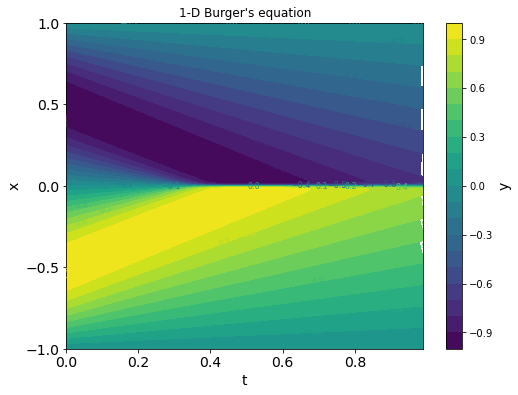

In [81]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, y_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Burger's equation")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

# Preparing Data

In [82]:
# reshaping the data for feeding to the model
data_input_all = torch.hstack((x_grid.flatten().view(-1,1), t_grid.flatten().view(-1,1)))
data_output_all = y_grid.flatten().view(-1,1)

In [83]:
lb = data_input_all[0]
ub = data_input_all[-1]

In [84]:
# selecting the desired number of data points from the whole data

data_input_initial = torch.hstack((x_grid[:,0].view(-1,1), t_grid[:,0].view(-1,1)))
data_output_initial = y_grid[:,0].view(-1,1)

data_input_boundary1 = torch.hstack((x_grid[0,:].view(-1,1), t_grid[0,:].view(-1,1)))
data_output_boundary1 = y_grid[0,:].view(-1,1)

data_input_boundary2 = torch.hstack((x_grid[-1,:].view(-1,1), t_grid[-1,:].view(-1,1)))
data_output_boundary2 = y_grid[-1,:].view(-1,1)

data_input_boundary_initial = torch.vstack([data_input_initial, data_input_boundary1, data_input_boundary2])
data_output_boundary_initial = torch.vstack([data_output_initial, data_output_boundary1, data_output_boundary2])

idx = np.random.choice(data_input_boundary_initial.shape[0], size=num_initial_boundary, replace=False)
x_BC_IC = data_input_boundary_initial[idx, :]
u_BC_IC = data_output_boundary_initial[idx, :]

x_col = lb + (ub-lb) * lhs(x_BC_IC.shape[1], num_domain)
x_col = torch.vstack((x_col, x_BC_IC))

In [85]:
print(f"{x_BC_IC.shape[0]} boundary and initial points for initial and boundary loss.")
print(f"{x_col.shape[0]} collocation points inside the domain including boundaries for PDE loss.")

200 boundary and initial points for initial and boundary loss.
5200 collocation points inside the domain including boundaries for PDE loss.


In [86]:
class PhysicsInformedNet(nn.Module):
    
    def __init__(self, layer_sizes, activation=nn.Tanh()):
        super(PhysicsInformedNet, self).__init__()
        
        self.layers = []
        
        for i in range(1, len(layer_sizes)-1):       # defining the neural network
            self.layers.extend([nn.Linear(layer_sizes[i-1], layer_sizes[i]), activation])
            
        self.layers.extend([nn.Linear(layer_sizes[-2], layer_sizes[-1])])
        
        self.net = nn.Sequential(*self.layers)

        # Initialize weights using Xavier initialization and biases to zero
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

In [87]:
# Define the physics-based model
def PDE(x_col):
    
    x = x_col.clone()
    x.requires_grad = True
    u = model(x)
    u_x_u_t = torch.autograd.grad(u, x, grad_outputs = torch.ones(u.shape), create_graph=True)[0] # [0] element inside the tuple
    u_x, u_t = u_x_u_t[:, 0:1], u_x_u_t[:, 1:]
    u_xx_u_tt = torch.autograd.grad(u_x_u_t, x, grad_outputs = torch.ones(u_x_u_t.shape), create_graph=True)[0]
    u_xx = u_xx_u_tt[:, 0:1]
    
    return u_t + u * u_x - 0.01/np.pi * u_xx


# Define the loss function
def loss_func(x_col, x_BC_IC, u_BC_IC, model):
    u_pred = model(x_BC_IC)
    loss_BC_IC = F.mse_loss(u_pred, u_BC_IC)
    f_pred = PDE(x_col)
    loss_PDE = torch.mean(f_pred**2)
    loss = loss_PDE + loss_BC_IC 
    return loss

In [88]:
# creating the model object and the optimizer

model = PhysicsInformedNet(layer_sizes, activation)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [89]:
%%time
Loss_his = []
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(x_col, x_BC_IC, u_BC_IC, model)
    loss.backward()
    optimizer.step()
    Loss_his.append(loss.detach().cpu().numpy())
    if i%(num_epochs/10)==0:
        print(loss.detach().cpu().numpy())

0.5269505982942613
0.013272394997256194
0.004544499022619088
0.0020238896637843552
0.0017312022413122294
0.001317444943346591
0.0015611991042478038
0.0010301915412988694
0.0011575948747285644
0.0018993559665893356
CPU times: user 28min 12s, sys: 26min 26s, total: 54min 38s
Wall time: 7min 52s


### Fine tuning the model

In [90]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [91]:
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(x_col, x_BC_IC, u_BC_IC, model)
    loss.backward()
    optimizer.step()
    Loss_his.append(loss.detach().cpu().numpy())
    if i%(num_epochs/10)==0:
        print(f'Loss: {loss.detach().cpu().numpy()}')

Loss: 0.0003428735887268655
Loss: 0.00028236103201517113
Loss: 0.00023531423502014872
Loss: 0.00020355903947124476
Loss: 0.00019584485136264784
Loss: 0.0001627304870548989
Loss: 0.00014861371114894488
Loss: 0.000137045218442865
Loss: 0.00022642010483805283
Loss: 0.00011907339919120052


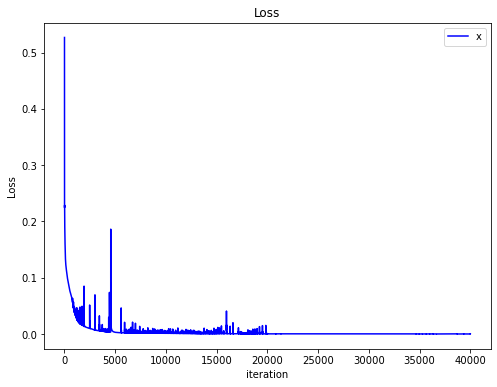

In [92]:
# plotting the Loss over iteration
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.array(Loss_his),'b-',label='x',)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Ploting the results
### True solution

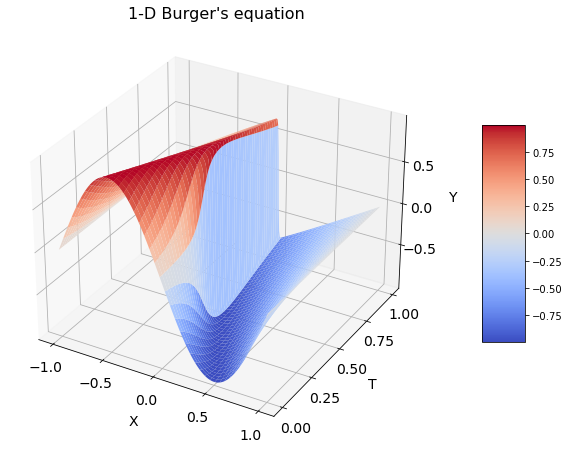

In [93]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, t_grid, y_grid, cmap='coolwarm', edgecolor='none')
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=6)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=.1)
ax.set_xlabel('X', fontsize=14, labelpad=10)
ax.set_ylabel('T', fontsize=14, labelpad=10)
ax.set_zlabel('Y', fontsize=14, labelpad=10)
ax.set_title("1-D Burger's equation", fontsize=16)

plt.show()

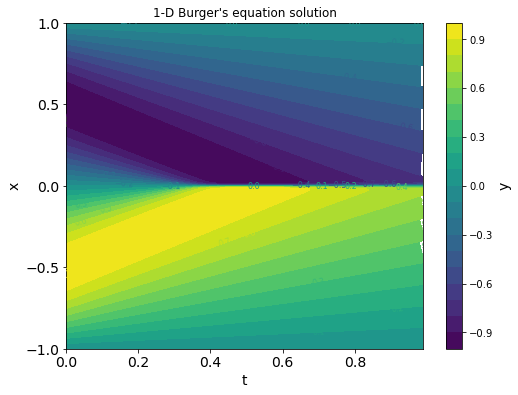

In [94]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, y_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Burger's equation solution")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

In [95]:
# using the train model to predict the solution
u_p = model(data_input_all)
u_p = u_p.view(x_grid.shape[0], x_grid.shape[1])

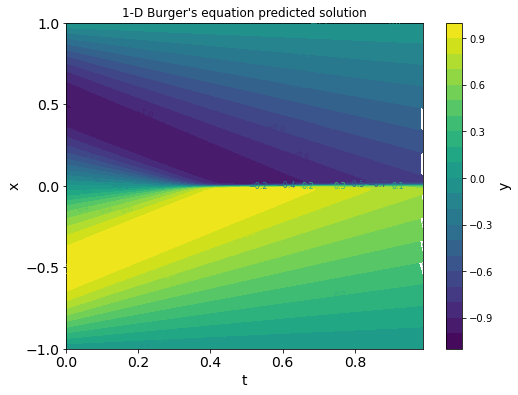

In [96]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, u_p.detach().cpu().numpy(), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Burger's equation predicted solution")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

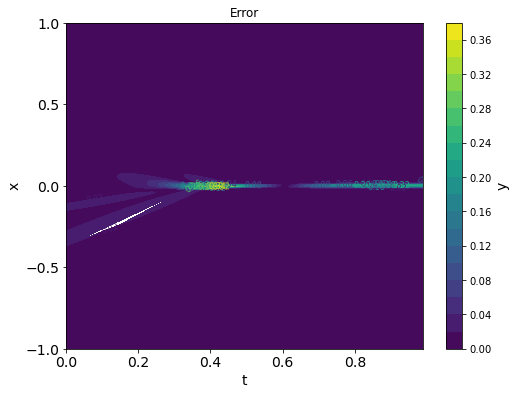

In [98]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, np.abs(u_p.detach().cpu().numpy()-y_grid.detach().cpu().numpy()), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("Error")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()